<a href="https://www.kaggle.com/code/ailafelixa/pharma-sales-analysis?scriptVersionId=116512875" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(42)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pharma-sales-data/salesdaily.csv
/kaggle/input/pharma-sales-data/salesweekly.csv
/kaggle/input/pharma-sales-data/salesmonthly.csv
/kaggle/input/pharma-sales-data/saleshourly.csv


### Descrição dos dados ###
[Descrição completa e fonte podem ser encontradas aqui](https://www.kaggle.com/datasets/milanzdravkovic/pharma-sales-data) 

The dataset is built from the initial dataset consisted of 600000 transactional data collected in 6 years (period 2014-2019), indicating date and time of sale, pharmaceutical drug brand name and sold quantity, exported from Point-of-Sale system in the individual pharmacy. Selected group of drugs from the dataset (57 drugs) is classified to the following Anatomical Therapeutic Chemical (ATC) Classification System categories:

M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances

M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives

N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives

N02BE/B - Other analgesics and antipyretics, Pyrazolones and Anilides

N05B - Psycholeptics drugs, Anxiolytic drugs

N05C - Psycholeptics drugs, Hypnotics and sedatives drugs

R03 - Drugs for obstructive airway diseases

R06 - Antihistamines for systemic use

____________________________________________________

#### **Nosso objetivo é avaliar a venda de diferentes medicamentos, de modo a conseguir capturar alguns insigths importantes como:**
#### 
*1.Quais classes de medicamentos estão apresentando aumento ou diminuição de demanda ao longo dos anos?*

*2. Quais os meses com mais e menos vendas?*

*3. Quais as classes de medicamentos mais e menos vendidos por mês?*

## Importação e pré-processamento ##

In [2]:
#Primeiro, vamos importar e checar a estrutura dos dados
pharma_sales_data = pd.read_csv('/kaggle/input/pharma-sales-data/salesmonthly.csv')
pharma_sales_data.head()
#pharma_sales_data.tail()

#Podemos notar que os dados já estão ordenados pela data e que a coleta dos dados ocorre no último dia de cada mês.
#Vamos ver em qual formato os dados estão armazenados
pharma_sales_data.dtypes

#A coluna de data está com tipo 'object', mas para trabalharmos com as datas corretamente devemos converte-la para o tipo datetime64
pharma_sales_data['datum'] = pd.to_datetime(pharma_sales_data['datum'], format='%Y-%m-%d')
pharma_sales_data.dtypes

datum    datetime64[ns]
M01AB           float64
M01AE           float64
N02BA           float64
N02BE           float64
N05B            float64
N05C            float64
R03             float64
R06             float64
dtype: object

In [3]:
#Vamos verificar também algumas informações relevantes sobre o nosso dataset, como por exemplo o número de linhas, número de colunas e quantidade de valores nulos
pharma_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   datum   70 non-null     datetime64[ns]
 1   M01AB   70 non-null     float64       
 2   M01AE   70 non-null     float64       
 3   N02BA   70 non-null     float64       
 4   N02BE   70 non-null     float64       
 5   N05B    70 non-null     float64       
 6   N05C    70 non-null     float64       
 7   R03     70 non-null     float64       
 8   R06     70 non-null     float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 5.0 KB


Como podemos ver, nosso dataset tem 70 linhas e 9 colunas e não possui valores nulos. Agora podemos começa a responder as nossas perguntas.

### 1. Quais classes de medicamentos apresentaram aumento ou diminuição de demanda ao longo dos anos? ##

In [4]:
#Primeiro vamos selecionar os dados referentes aos anos de 2014 (nosso start-point) e de 2019 (nosso end-point)
df_1 = pharma_sales_data.loc[(pharma_sales_data.datum.dt.year == 2014) | (pharma_sales_data.datum.dt.year == 2019)]
df_1.loc[:,'datum'] = df_1.datum.dt.year
df_1 = df_1.groupby('datum').sum() #Calculando a quantidade de vendas para cada classe de medicamento em cada ano
df_1.head()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
datum,,,,,,,,
2014,1510.77,1333.594,1683.279,10094.555,4355.0,303.0,1277.0,828.30
2019,1517.27,1117.221,879.800,8011.616,2405.6,196.0,2050.0,1073.57


In [5]:
#Vamos calcular o delta (diferença no número de unidades vendidas no ano de 2019 menos o número de unidades vendidas no ano de 2014)
delta = df_1.diff()
delta = delta.reset_index()
delta = delta.loc[delta.datum == 2019]
delta = delta.drop(columns='datum')
delta = round(delta)
delta_str = delta.applymap(str) #Gerando um dataframe de strings para auxiliar na legenda dos gráficos

In [6]:
#Vamos calcular também a proporção de crescimento ou decréscimo comparando 2019 com 2014
proporcao = df_1.iloc[1]/df_1.iloc[0]
proporcao = pd.DataFrame(proporcao)
proporcao = proporcao.rename(columns={0:'proporcao'})
proporcao = round(proporcao,2) #arredondando os valores para duas casas decimais apenas

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

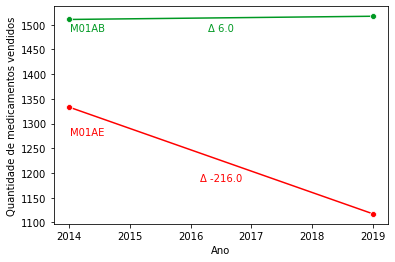

In [7]:
# Vamos comparar o desempenho de medicamentos com ATC similares, começando pelos anti-inflamatórios
ax = sns.lineplot(x=df_1.index, y=df_1.M01AB, ci = None, marker='o', color='#009923')
plt.text(0.1, 0.9, df_1.columns[0], horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, color='#009923')
plt.text(0.5, 0.9, 'Δ '+delta_str.iloc[0,0], horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, color='#009923')
bx = sns.lineplot(x=df_1.index, y=df_1.M01AE, ci = None, marker='o', color='red')
plt.text(0.1, 0.42, df_1.columns[1], horizontalalignment='center',
     verticalalignment='center', transform=bx.transAxes,color='red')
plt.text(0.5, 0.21, 'Δ '+delta_str.iloc[0,1], horizontalalignment='center',
     verticalalignment='center', transform=bx.transAxes,color='red')
ax.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

No caso dos medicamentos anti-inflamatórios e antireumáticos, aqueles derivados de ácido acético manteram um nível aproximadamente constante de vendas entre o primeiro e o último ano da análise. Já os medicamentos da mesma classe, mas derivados de ácido propiônico tiveram uma queda acentuada. 

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

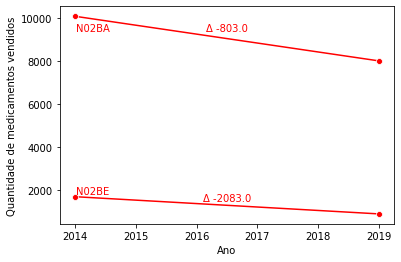

In [8]:
#Outros analgésicos e anti-piréticos
cx = sns.lineplot(x=df_1.index, y=df_1.N02BA, ci = None, marker='o', color='red')
plt.text(0.1, 0.90, df_1.columns[2], horizontalalignment='center',
     verticalalignment='center', transform=cx.transAxes, color='red')
plt.text(0.5, 0.9, 'Δ '+delta_str.iloc[0,2], horizontalalignment='center',
     verticalalignment='center', transform=cx.transAxes, color='red')
dx = sns.lineplot(x=df_1.index, y=df_1.N02BE, ci = None, marker='o', color='red')
plt.text(0.1, 0.15, df_1.columns[3], horizontalalignment='center',
     verticalalignment='center', transform=dx.transAxes, color='red')
plt.text(0.5, 0.12, 'Δ '+delta_str.iloc[0,3], horizontalalignment='center',
     verticalalignment='center', transform=dx.transAxes, color='red')
cx.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

No caso de outros analgésicos e anti-piréticos, a queda foi ainda mais acentuada, principalmente para medicamentos da classe N02BE

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

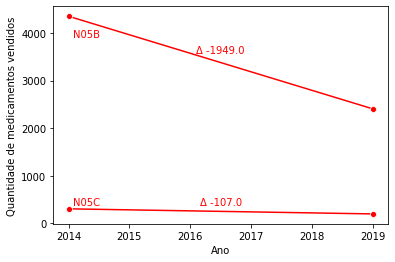

In [9]:
#Psicolépticos
ex=sns.lineplot(x=df_1.index, y=df_1.N05B, ci = None, marker='o', color='red')
plt.text(0.1, 0.87, df_1.columns[4], horizontalalignment='center',
     verticalalignment='center', transform=ex.transAxes, color='red')
plt.text(0.5, 0.80, 'Δ '+delta_str.iloc[0,4], horizontalalignment='center',
     verticalalignment='center', transform=ex.transAxes, color='red')
fx=sns.lineplot(x=df_1.index, y=df_1.N05C, ci = None, marker='o', color='red')
plt.text(0.1, 0.1, df_1.columns[5], horizontalalignment='center',
     verticalalignment='center', transform=fx.transAxes, color='red')
plt.text(0.5, 0.1, 'Δ '+delta_str.iloc[0,5], horizontalalignment='center',
     verticalalignment='center', transform=fx.transAxes, color='red')
ex.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

No caso dos psicolépticos também houve diminuição nas vendas das duas classes, com destaque para a classe N05B que vendeu quase 2000 unidades a menos em 2019 quando comparado a 2014

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

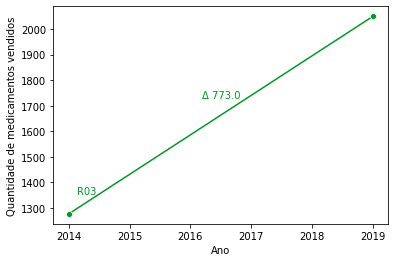

In [10]:
#Fármacos para o tratamento de doenças pulmonares obstrutivas
r1x = sns.lineplot(x=df_1.index, y=df_1.R03, ci = None, marker='o', color='#009923')
plt.text(0.1, 0.15, df_1.columns[6], horizontalalignment='center',
     verticalalignment='center', transform=r1x.transAxes, color='#009923')
plt.text(0.5, 0.59, 'Δ '+delta_str.iloc[0,6], horizontalalignment='center',
     verticalalignment='center', transform=r1x.transAxes, color='#009923')
r1x.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

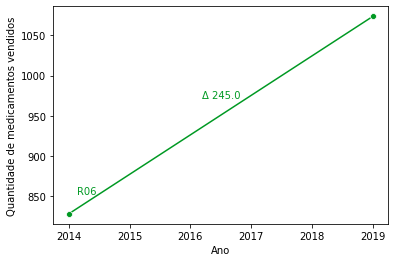

In [11]:
#Anti-histamínicos
r2x = sns.lineplot(x=df_1.index, y=df_1.R06, ci = None, marker='o', color='#009923')
plt.text(0.1, 0.15, df_1.columns[7], horizontalalignment='center',
     verticalalignment='center', transform=r2x.transAxes, color='#009923')
plt.text(0.5, 0.59, 'Δ '+delta_str.iloc[0,7], horizontalalignment='center',
     verticalalignment='center', transform=r2x.transAxes, color='#009923')
r2x.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

Por fim, os fármacos das classes R03 e R06 ambos apresentaram crescimento nas vendas quando compara-se o primeiro e o último ano de análise

<AxesSubplot:ylabel='proporcao'>

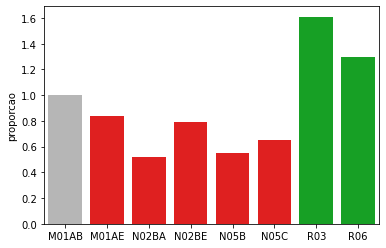

In [12]:
#Agora vamos visualizar os dados juntos para termos uma noção global do crescimento e decréscimo proporcional para cada medicamento
#Para não ter que definir manualmente todas as cores, vamos elaborar uma paleta de cores de forma condicional
cores_prop = ['red' if num < 1 else '#00B713' if num > 1 else '#B6B6B6' for num in proporcao.proporcao]
sns.barplot(x=proporcao.index, y=proporcao.proporcao, palette=cores_prop)

Fazemos uma comparação nas proporções, vemos que:
* Fármacos da classe M01AB mantiveram as vendas aproximadamente constantes nos dois pontos de medida
* Fármacos das classes R03 e R06 aumentaram as vendas em quase 2x em 2019 quando comparado a 2014
* O restante dos fármacos tiveram resultados piores em 2019 do que em 2014, com destaque para o N02BA que vendeu quase 50% a menos em 2019 do que em 2014. 

In [13]:
#Vamos analisar agora a performance de M01AB, N02BA e R03 considerando todos os anos que temos dispoíveis para tentar entender o que pode ter acontecido nesses três casos
#onde respectivamente não tivemos crescimento, tivemos decréscimo de vendas e tivemos aumento de vendas entre o start-point e o end-point

df_1b = pharma_sales_data.loc[:,['datum','M01AB','N02BA','R03']]
df_1b.loc[:,'datum'] = df_1b.datum.dt.year
df_1b = df_1b.groupby('datum').sum() #Calculando a quantidade de vendas para cada classe de medicamento em cada ano
df_1b

,M01AB,N02BA,R03
datum,,,
2014,1510.77,1683.279,1277.00
2015,1905.62,1608.630,1776.25
2016,2125.06,1664.800,2137.00
2017,1653.79,1091.150,1732.00
2018,1786.93,1123.800,2765.00
2019,1517.27,879.800,2050.00


Text(0.05, 0.2, 'R03')

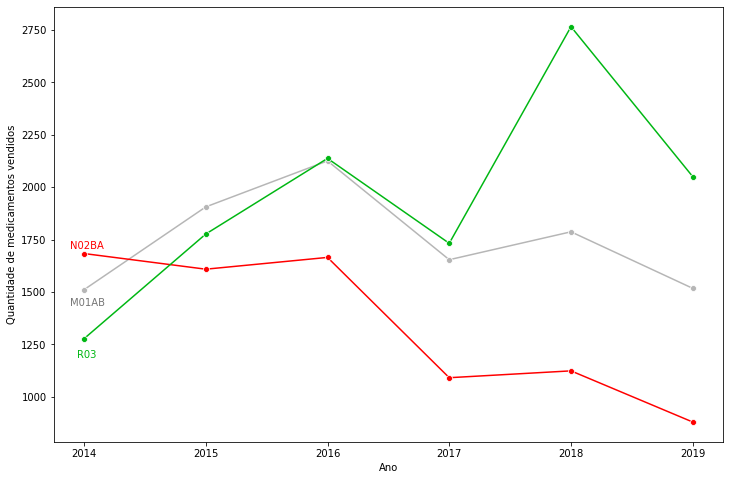

In [14]:
#Vamos manter o mesmo código de cores utilizados na visualização das proporções para facilitar a intepretação do gráfico
m01ab = sns.lineplot(x=df_1b.index, y=df_1b.M01AB, ci = None, marker='o', color='#B6B6B6')
plt.text(0.05, 0.32, df_1b.columns[0], horizontalalignment='center',
     verticalalignment='center', transform=m01ab.transAxes, color='#757575')
m01ab.figure.set_size_inches(12, 8)
m01ab.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

n02ba = sns.lineplot(x=df_1b.index, y=df_1b.N02BA, ci = None, marker='o', color='red')
plt.text(0.05, 0.45, df_1b.columns[1], horizontalalignment='center',
     verticalalignment='center', transform=n02ba.transAxes, color='red')

r03 = sns.lineplot(x=df_1b.index, y=df_1b.R03, ci = None, marker='o', color='#00B713')
plt.text(0.05, 0.20, df_1b.columns[2], horizontalalignment='center',
     verticalalignment='center', transform=r03.transAxes, color='#00B713')

### Existem alguns pontos interessantes que podem ser destacados ao analisar esse gráfico para cada uma das três classes de medicamentos ###
* **Os medicamentos da classe M01AB tiveram um acentuado crescimento de vendas entre 2014 e 2016, onde as vendas começaram a declinar.**
    * Apesar de uma pequena recuperação ter acontecido entre 2017 e 2018, os medicamentos dessa classe, no último ponto de análise, tiveram uma performance muito similar ao visto em 2014
    * Assim, apesar de na análise de proporção as vendas parecerem constantes, na verdade elas estão em queda. Isso ressalta a importância de se analisar o histórico inteiro, visto que delinear ações de contenção ou de reversão para vendas em queda podem exigir diferentes abordagens do que ações direcionadas para impulsionar vendas estagnadas
    
    
* **As vendas de medicamentos da classe dos N02BA decresceram desde 2014, tendo uma diminuição mais acentuada entre 2016 e 2017 e atingindo o seu menor nível em 2019.**

* **Os medicamentos da classe R03, usados para tratamento de doenças obstrutivas das vias aéres, tiveram um grande crescimento entre 2014 e 2018, atingindo seu maior nível nesse ano**
    * Apesar disso, houve uma queda acentuada de vendas entre 2018 e 2019; a presença dessa informação também permite uma tomada de decisão mais alinhada com a realidade do número de vendas

É interessante observar que houve quedas nas vendas das três classes de medicamentos entre 2018 e 2019. Seria interessante analisar quais fatores internos (por exemplo questões financeiras, reestruturações, etc) e externos (mudanças econômicas, de regulamentação, epidemiológicas, etc.) poderiam ter influenciado nesses resultados. 


### 2. Quais os meses com mais e menos vendas? ##

In [15]:
#Para responder a essa pergunta vamos começar novamente tratando nossos dados para que fiquem da forma que precisamos
#Para isso criaremos uma amostra dos dados agrupados por mês, independente do ano
df_2 = deepcopy(pharma_sales_data)
df_2.loc[:,'month'] = df_2.datum.dt.month
df_2 = df_2.groupby('month').mean() #calculando a média de vendas por mês
df_2 = round(df_2,2)
df_2

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
month,,,,,,,,
1,124.54,114.94,111.07,1032.26,265.03,22.00,178.04,39.58
2,137.44,127.63,127.48,993.83,248.40,15.17,195.17,46.73
3,152.28,123.14,123.81,927.92,256.23,19.33,204.17,98.72
4,153.54,107.70,112.32,776.82,239.90,15.50,184.50,141.12
5,150.23,113.14,115.19,714.66,235.30,18.83,163.33,155.09
6,141.44,107.04,115.95,624.25,242.50,17.67,130.50,133.11
7,164.58,117.02,107.98,610.26,257.27,14.83,91.67,104.12
8,169.95,112.36,107.79,654.82,281.67,19.00,96.17,83.38
9,150.15,119.10,102.89,960.86,277.22,15.67,138.67,77.20


In [16]:
#Vamos criar uma segunda amostra contendo mês e ano para verificar se existem peculiaridades associadas ao mês e ano
df_2y = deepcopy(pharma_sales_data)
df_2y.loc[:,'year'] = df_2y.datum.dt.year
df_2y.loc[:,'month'] = df_2y.datum.dt.month
df_2y = df_2y.drop('datum', axis=1)
df_2y

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,year,month
0,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.20,2014,1
1,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.20,2014,2
2,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.40,2014,3
3,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.70,2014,4
4,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.70,2014,5
...,...,...,...,...,...,...,...,...,...,...
65,151.54,101.627,103.200,610.000,193.0,25.0,142.0,156.04,2019,6
66,181.00,103.541,92.800,649.800,250.6,20.0,115.0,105.20,2019,7
67,181.91,88.269,84.200,518.100,237.0,26.0,145.0,97.30,2019,8
68,161.07,111.437,93.500,984.480,227.8,16.0,161.0,109.10,2019,9


Text(0.12, 0.51, 'Média geral')

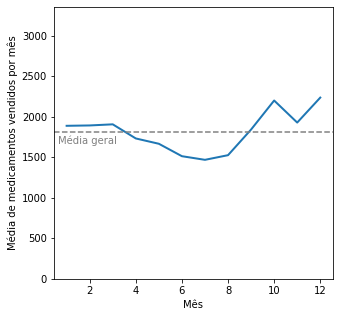

In [17]:
#Vamos verificar como a média de vendas se comporta ao longo dos meses, independentemente do produto 
df_2a = df_2.sum(axis=1)
df_2a = pd.DataFrame(df_2a)
df_2a = df_2a.rename(columns={0:'total'})
 
df2ax = sns.lineplot(x = df_2a.index, y=df_2a.total, **{'lw':'2'})
df2ax.figure.set_size_inches(5, 5)
df2ax.set(xlabel='Mês', ylabel='Média de medicamentos vendidos por mês')
plt.ylim(0, df_2a['total'].max()*1.5)
plt.axhline(df_2a.total.mean(),xmin=0, xmax=1, color='grey', **{'ls':'--'})
plt.text(0.12, 0.51, 'Média geral', horizontalalignment='center',
     verticalalignment='center', transform=df2ax.transAxes, color='grey')

Podemos observar que as vendas ficam abaixo da média de abril a setembro e atingem seu maior volume nos meses de outubro e dezembro. Portanto, existe uma sazonalidade na venda dessas classes de fármacos, o que deve ser mantido em consideração ao fazer o planejamento de produção, logística e ações de marketing.

Text(0.5, 1.0, '2019')

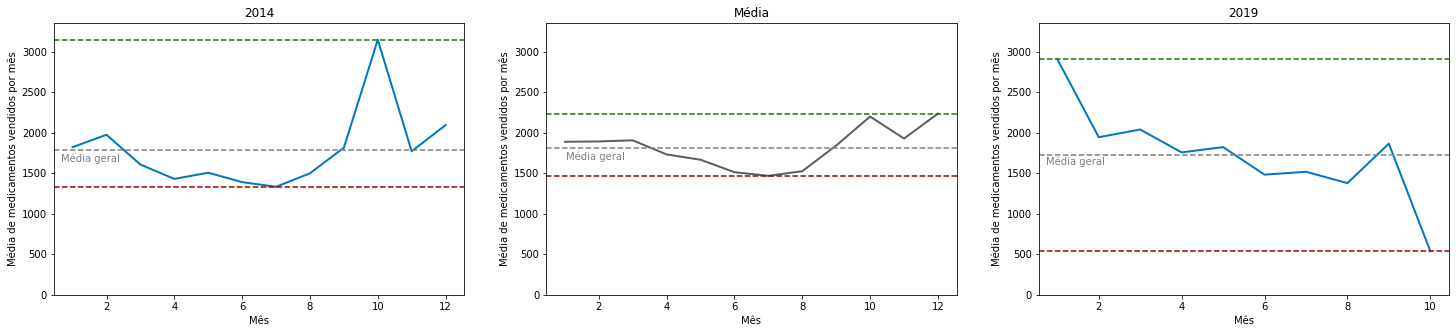

In [18]:
### Vamos analisar agora se essa tendência média se repete nos anos de 2014 (nosso start-point) e 2019 (nosso end-point)
df_2y2014 = df_2y.loc[df_2y['year']==2014]
df_2y2014 = df_2y2014.drop('year', axis=1)
df_2y2014 = df_2y2014.set_index('month')
df_2y2014 = df_2y2014.sum(axis=1)

df_2y2014 = pd.DataFrame(df_2y2014)
df_2y2014 = df_2y2014.rename(columns={0:'total'})

plt.subplots(figsize=(25, 5)) 
plt.subplot(1, 3, 1) 
df_2y2014ax = sns.lineplot(x = df_2y2014.index, y=df_2y2014.total, color='#0077C0',**{'lw':'2'})
#df_2y2014ax.figure.set_size_inches(5, 5)
df_2y2014ax.set(xlabel='Mês', ylabel='Média de medicamentos vendidos por mês')
plt.ylim(0, df_2a['total'].max()*1.5)
plt.axhline(df_2y2014.total.mean(),xmin=0, xmax=1, color='grey', **{'ls':'--'})
plt.axhline(df_2y2014.total.max(),xmin=0, xmax=1, color='#1C7A00', **{'ls':'--'})
plt.axhline(df_2y2014.total.min(),xmin=0, xmax=1, color='#9C0000', **{'ls':'--'})
plt.text(0.09, 0.50, 'Média geral', horizontalalignment='center',
     verticalalignment='center', transform=df_2y2014ax.transAxes, color='grey')
plt.title('2014')

plt.subplot(1, 3, 2) 
df2ax = sns.lineplot(x = df_2a.index, y=df_2a.total, color='#5C5E5F', **{'lw':'2'})
#df2ax.figure.set_size_inches(5, 5)
df2ax.set(xlabel='Mês', ylabel='Média de medicamentos vendidos por mês')
plt.ylim(0, df_2a['total'].max()*1.5)
plt.axhline(df_2a.total.mean(),xmin=0, xmax=1, color='grey', **{'ls':'--'})
plt.axhline(df_2a.total.max(),xmin=0, xmax=1, color='#1C7A00', **{'ls':'--'})
plt.axhline(df_2a.total.min(),xmin=0, xmax=1, color='#9C0000', **{'ls':'--'})
plt.text(0.12, 0.51, 'Média geral', horizontalalignment='center',
     verticalalignment='center', transform=df2ax.transAxes, color='grey')
plt.title('Média')


df_2y2019 = df_2y.loc[df_2y['year']==2019]
df_2y2019 = df_2y2019.drop('year', axis=1)
df_2y2019 = df_2y2019.set_index('month')
df_2y2019 = df_2y2019.sum(axis=1)

df_2y2019 = pd.DataFrame(df_2y2019)
df_2y2019 = df_2y2019.rename(columns={0:'total'})

plt.subplot(1, 3, 3) 
df_2y2019ax = sns.lineplot(x = df_2y2019.index, y=df_2y2019.total, color='#0077C0',**{'lw':'2'})
#df_2y2014ax.figure.set_size_inches(5, 5)
df_2y2019ax.set(xlabel='Mês', ylabel='Média de medicamentos vendidos por mês')
plt.ylim(0, df_2a['total'].max()*1.5)
plt.axhline(df_2y2019.total.mean(),xmin=0, xmax=1, color='grey', **{'ls':'--'})
plt.axhline(df_2y2019.total.max(),xmin=0, xmax=1, color='#1C7A00', **{'ls':'--'})
plt.axhline(df_2y2019.total.min(),xmin=0, xmax=1, color='#9C0000', **{'ls':'--'})
plt.text(0.09, 0.49, 'Média geral', horizontalalignment='center',
     verticalalignment='center', transform=df_2y2019ax.transAxes, color='grey')
plt.title('2019')